### 1. Preparación del dataset

#### 1.1. Lectura del conjunto de datos

In [1]:
from scipy.io import loadmat
data=loadmat("Indian_pines_corrected_image.mat")['indian_pines_corrected']
labels=loadmat("Indian_pines_ground_truth.mat")['indian_pines_gt']
H,W,C=data.shape

#### 1.2. Reducción de la dimensionalidad

In [2]:
from sklearn.decomposition import PCA
n_components=22 # Nuestro análisis abarca 20 bandas
data=data.reshape(H*W,C)
pca=PCA(n_components=n_components,whiten=True)
data=pca.fit_transform(data)

#### 1.3. Normalización de los datos

In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
standar_scaler=StandardScaler()
data=standar_scaler.fit_transform(data)
data=data.reshape(H,W,n_components);

#### 1.4. Aproximación parche a pixel

In [4]:
import numpy as np

def padWithZeros(X, margin=2):
    newX=np.zeros((X.shape[0]+2*margin,X.shape[1]+2*margin, X.shape[2]))
    x_offset=margin
    y_offset=margin 
    newX[x_offset:X.shape[0]+x_offset, y_offset:X.shape[1]+y_offset,:]=X
    return newX

def createImageCubes(X,y,windowSize=9, removeZeroLabels=True): #Regresar a 5
    margin=int((windowSize-1)/2)
    zeroPaddedX=padWithZeros(X,margin=margin)
    patchesData=np.zeros((X.shape[0]*X.shape[1],windowSize,windowSize,X.shape[2]))
    patchesLabels=np.zeros((X.shape[0]*X.shape[1]))
    patchIndex=0
    for r in range(margin,zeroPaddedX.shape[0]-margin):
        for c in range(margin,zeroPaddedX.shape[1]-margin):
            patch=zeroPaddedX[r-margin:r+margin+1,c-margin:c+margin+1]
            patchesData[patchIndex,:,:,:]=patch 
            patchesLabels[patchIndex]=y[r-margin,c-margin]
            patchIndex=patchIndex+1
    if removeZeroLabels:
        patchesData=patchesData[patchesLabels>0,:,:,:]
        patchesLabels=patchesLabels[patchesLabels>0]
        patchesLabels -=1
    from keras.utils import np_utils
    patchesLabels=np_utils.to_categorical(patchesLabels)
    return patchesData,patchesLabels 

#### 1.5. Acondicionar el conjunto de datos

In [5]:
x_train,y_train=createImageCubes(data,labels,removeZeroLabels=False)

In [6]:
n_clases=y_train.shape[1]

In [7]:
x_train=x_train.reshape(-1,81,n_components)

#### 1.6. Partir Dataset

In [8]:
# TEST 40%, TRAIN 48%, VALIDATION 12%
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,test_size=0.4,shuffle=True,random_state=0,stratify=y_train) #0.4 100% 0.9--0.79
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.2,shuffle=True,random_state=0,stratify=y_train)

### 2. Red Neuronal Convolucional

In [9]:
import tensorflow as tf 
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model 
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
class ClassToken(Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value = w_init(shape=(1,1,input_shape[-1]), dtype=tf.float32),
            trainable = True 
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        hidden_dim = self.w.shape[-1]

        cls=tf.broadcast_to(self.w, [batch_size,1,hidden_dim])
        cls=tf.cast(cls, dtype=inputs.dtype)
        return cls

In [11]:
""" Inputs """ 
shape_input=(81,n_components)
inputs=Input(shape_input)

""" Patch + Position Embeddings """ 

patch_embed = Dense(n_components)(inputs)
positions=tf.range(start=0, limit=81, delta=1)
pos_embed=Embedding(input_dim=n_components,output_dim=n_components)(positions)
embed=patch_embed+pos_embed

""" Adding Class Token """ 

token=ClassToken()(embed)
x=Concatenate(axis=1)([token,embed])

""" Transformer """

# Transformer Block 1

skip_1=x
x=LayerNormalization()(x)
x=MultiHeadAttention(num_heads=3,key_dim=n_components)(x,x)
x=Add()([x,skip_1])


x=LayerNormalization()(x)
x=Dense(128,activation="gelu")(x)
x=Dropout(0.5)(x)
x=Dense(64,activation="relu")(x) 
x=Dropout(0.5)(x)
""" Clasificacion """ 

x=Flatten()(x)

x=Dense(243,activation="relu")(x)
x=Dropout(0.5)(x)
x=Dense(n_clases,activation="relu")(x)

x=Dense(n_clases,activation="softmax")(x)
model=Model(inputs,x)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [12]:
callback=EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)

#### 2.1. Entrenamiento

In [13]:
history=model.fit(x_train,y_train,epochs=100,batch_size=128,validation_data=(x_val,y_val),callbacks=[callback])

Epoch 1/100
79/79 [==============================] - 10s 90ms/step - loss: 1.4966 - accuracy: 0.5655 - val_loss: 1.0432 - val_accuracy: 0.6667
Epoch 2/100
79/79 [==============================] - 5s 64ms/step - loss: 0.9423 - accuracy: 0.6984 - val_loss: 0.7439 - val_accuracy: 0.7495
Epoch 3/100
79/79 [==============================] - 5s 62ms/step - loss: 0.7102 - accuracy: 0.7729 - val_loss: 0.5528 - val_accuracy: 0.8070
Epoch 4/100
79/79 [==============================] - 5s 64ms/step - loss: 0.5559 - accuracy: 0.8090 - val_loss: 0.4433 - val_accuracy: 0.8450
Epoch 5/100
79/79 [==============================] - 5s 63ms/step - loss: 0.4610 - accuracy: 0.8411 - val_loss: 0.3273 - val_accuracy: 0.8918
Epoch 6/100
79/79 [==============================] - 5s 62ms/step - loss: 0.3859 - accuracy: 0.8657 - val_loss: 0.3015 - val_accuracy: 0.8966
Epoch 7/100
79/79 [==============================] - 5s 62ms/step - loss: 0.3354 - accuracy: 0.8832 - val_loss: 0.2838 - val_accuracy: 0.8958
Epoch

In [14]:
dic_curves_IP={}
dic_curves_IP["val_accuracy"]=history.history["val_accuracy"]
dic_curves_IP["accuracy"]=history.history["accuracy"]
dic_curves_IP["loss"]=history.history["loss"]
dic_curves_IP["val_loss"]=history.history["val_loss"]

import pickle 

with open("accu_loss_transformer.pkl","wb") as f:
    pickle.dump(dic_curves_IP,f)

#### 3. Evaluación

#### 3.1. Evaluacion Test

In [15]:
evaluacion_test=model.evaluate(x_test,y_test)

263/263 [==============================] - 4s 14ms/step - loss: 0.1072 - accuracy: 0.9678


#### 3.2. Classification Report

In [16]:
y_pred=model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
from sklearn.metrics import classification_report
clases_dataset_IP=["UNLABELED","ALFALFA","CORN-NOTILL","CORN_MINTILL","CORN","GRASS-PASTURE","GRASS_TREES","GRASS_PASTURE_MOWED","HAY_WINDROWED","OATS","SOYBEAN_NOTILL","SOYBEAN-MINTILL","SOYBEAN_CLEAN","WHEAT","WOODS","BUILDING_GRASS_TREES_DRIVES","STONE_STEEL_TOWERS"]
target_names=clases_dataset_IP
classification=classification_report(np.argmax(y_test,axis=1),y_pred,target_names=target_names)
print(classification)

263/263 [==============================] - 3s 11ms/step
                             precision    recall  f1-score   support

                  UNLABELED       0.97      0.97      0.97      4311
                    ALFALFA       0.94      0.83      0.88        18
                CORN-NOTILL       0.96      0.97      0.97       571
               CORN_MINTILL       0.97      0.98      0.97       332
                       CORN       0.95      0.95      0.95        95
              GRASS-PASTURE       0.93      0.98      0.96       193
                GRASS_TREES       0.97      0.96      0.96       292
        GRASS_PASTURE_MOWED       1.00      1.00      1.00        11
              HAY_WINDROWED       0.96      1.00      0.98       191
                       OATS       1.00      0.88      0.93         8
             SOYBEAN_NOTILL       0.95      0.98      0.96       389
            SOYBEAN-MINTILL       0.98      0.98      0.98       982
              SOYBEAN_CLEAN       0.98      0.

#### 3.3. Cohen Kappa

In [17]:
from sklearn.metrics import cohen_kappa_score
a=y_pred
b=np.argmax(y_test,axis=1)
cks=cohen_kappa_score(a,b)
cks

np.save("cohen_kappa_score_transformer",cks)

In [18]:
import numpy as np
np.load("cohen_kappa_score_transformer.npy")

array(0.954606)

In [19]:
import pandas as pd 

pd_reporte_clasificacion=pd.DataFrame(classification_report(np.argmax(y_test,axis=1),y_pred,target_names=target_names,output_dict=True)).transpose()
pd_reporte_clasificacion.to_csv("reporte_clasificacion_transformer.csv")

In [20]:
y_pred,_=createImageCubes(data,labels,removeZeroLabels=False)
y_pred=y_pred.reshape(-1,81,n_components)
y_pred=model.predict(y_pred,batch_size=128)
y_pred=np.argmax(y_pred,axis=1)
y_pred=y_pred.reshape(H,W)

165/165 [==============================] - 5s 27ms/step


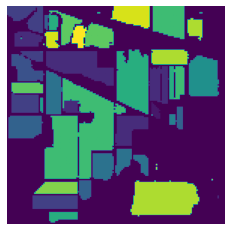

In [21]:
import matplotlib.pyplot as plt 
plt.imshow(y_pred)
plt.axis("off");

In [22]:
np.save("y_pred_transformer",y_pred)

(-0.5, 144.5, 144.5, -0.5)

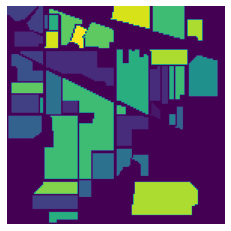

In [23]:
plt.imshow(labels)
plt.axis("off")

In [24]:
from sklearn.metrics import accuracy_score
a=y_pred.reshape(H*W)
b=labels.reshape(H*W)
cohen_kappa_score(a,b)

0.9774001057834881

In [25]:
accuracy_score(a,b)

0.9839714625445898

In [26]:
from keras.metrics import MeanIoU 
n_classes=17
IOU_mean=MeanIoU(num_classes=n_classes)
IOU_mean.update_state(y_pred,labels)
print("Mean IoU",IOU_mean.result().numpy())
np.save("IoU_transformer",IOU_mean.result().numpy()) #antes 0.9492

Mean IoU 0.95777535


In [27]:
# IoU por clase.
from keras.metrics import IoU
clases=["unlabeled","ALFALFA","CORN-NOTILL","CORN_MINTILL","CORN","GRASS-PASTURE","GRASS_TREES","GRASS_PASTURE_MOWED","HAY_WINDROWED","OATS","SOYBEAN_NOTILL","SOYBEAN-MINTILL","SOYBEAN_CLEAN","WHEAT","WOODS","BUILDING_GRASS_TREES_DRIVES","STONE_STEEL_TOWERS"]
IoU_class_report=[]
for i in range(17):
    IoU_class=IoU(num_classes=17,target_class_ids=[i])
    IoU_class.update_state(y_pred,labels)
    IoU_class_report.append(IoU_class.result().numpy())
    print(clases[i],":", IoU_class.result().numpy())

unlabeled : 0.970219
ALFALFA : 0.9148936
CORN-NOTILL : 0.9643347
CORN_MINTILL : 0.97044915
CORN : 0.9508197
GRASS-PASTURE : 0.9561753
GRASS_TREES : 0.9543624
GRASS_PASTURE_MOWED : 1.0
HAY_WINDROWED : 0.9814815
OATS : 0.95
SOYBEAN_NOTILL : 0.96392787
SOYBEAN-MINTILL : 0.98147404
SOYBEAN_CLEAN : 0.9414716
WHEAT : 0.99512196
WOODS : 0.968143
BUILDING_GRASS_TREES_DRIVES : 0.9594937
STONE_STEEL_TOWERS : 0.8598131


In [28]:
np.save("reporte_IoU_transformer",IoU_class_report)

In [29]:
from keras.metrics import IoU
clases=["UNLABELED","ALFALFA","CORN-NOTILL","CORN_MINTILL","CORN","GRASS-PASTURE","GRASS_TREES","GRASS_PASTURE_MOWED","HAY_WINDROWED","OATS","SOYBEAN_NOTILL","SOYBEAN-MINTILL","SOYBEAN_CLEAN","WHEAT","WOODS","BUILDING_GRASS_TREES_DRIVES","STONE_STEEL_TOWERS"]
IoU_class_report=[]
for i in range(n_clases):
    IoU_class=IoU(num_classes=n_clases,target_class_ids=[i])
    IoU_class.update_state(y_pred,labels)
    IoU_class_report.append(IoU_class.result().numpy())
    print(IoU_class.result().numpy())

0.970219
0.9148936
0.9643347
0.97044915
0.9508197
0.9561753
0.9543624
1.0
0.9814815
0.95
0.96392787
0.98147404
0.9414716
0.99512196
0.968143
0.9594937
0.8598131
